In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/var/folders/zk/_l6jn98j1ws6ndxrzcw2dh4m0000gn/T/ipykernel_72185/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [304]:
import sys
import os
import requests
import io
import folium
import collections
from folium import plugins
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import PathPatch
from collections import ChainMap
import urllib.request
import pylab
from nltk.corpus import words
from sklearn.preprocessing import MultiLabelBinarizer

#import nltk
#nltk.download()

sys.path.append( '/Users/kgray/Downloads/artemis/src/scripts' )
from parse_json import parse_json
from domain_tools import get_domain_parts

In [303]:
data_dir = '../data/raw/'

# Gather a list of data files
data_file_list = []
for filename in os.listdir(data_dir):
    if filename.startswith("benign") | filename.startswith("malicious"):
        f = os.path.join(data_dir, filename)
        if os.path.isfile(f):
            data_file_list.append((f, filename))

In [4]:
# Load data into memory via dict referenced by filename
data_file_dict = {}
for data_file in data_file_list:
    with open(data_file[0]) as f:
        data = f.read()
        
        data_list = []
        while True:
            obj, remaining = parse_json(data)
            data_list.append(obj)
            data = remaining
            if not remaining.strip():
                break
        data_file_dict[data_file[1]] = data_list

# Whois Data EDA

In [5]:
data_file_dict['malicious_whois_data.txt'][0]

{'reseptors.com': {'address': 'REDACTED FOR PRIVACY',
  'city': 'REDACTED FOR PRIVACY',
  'country': 'KN',
  'creation_date': ['2021-12-08 08:53:26', '2021-12-08T08:53:26'],
  'dnssec': 'unsigned',
  'domain_name': 'RESEPTORS.COM',
  'emails': 'domainabuse@tucows.com',
  'expiration_date': ['2022-12-08 08:53:26', '2022-12-08T08:53:26'],
  'name': 'REDACTED FOR PRIVACY',
  'name_servers': ['1-YOU.NJALLA.NO',
   '2-CAN.NJALLA.IN',
   '3-GET.NJALLA.FO',
   '1-you.njalla.no',
   '2-can.njalla.in',
   '3-get.njalla.fo'],
  'org': 'REDACTED FOR PRIVACY',
  'referral_url': None,
  'registrar': 'TUCOWS, INC.',
  'state': 'Charlestown',
  'status': ['clientTransferProhibited https://icann.org/epp#clientTransferProhibited',
   'clientUpdateProhibited https://icann.org/epp#clientUpdateProhibited'],
  'updated_date': ['2021-12-08 08:53:26', '2021-12-08T09:09:15'],
  'whois_server': 'whois.tucows.com',
  'zipcode': 'REDACTED FOR PRIVACY'}}

In [6]:
# Load data into dataframe, add type column, and merge
benign_whois_data = data_file_dict['benign_whois_data.txt']
malicious_whois_data = data_file_dict['malicious_whois_data.txt']

benign_whois_dict = {}
for domain_whois_dict in data_file_dict['benign_whois_data.txt']:
    domain_name = list(domain_whois_dict.keys())[0]
    if isinstance(domain_whois_dict[domain_name], dict) and 'creation_date' in domain_whois_dict[domain_name].keys():
        if isinstance(domain_whois_dict[domain_name]['creation_date'], list):
            domain_creation_date = domain_whois_dict[domain_name]['creation_date'][0]
        else:
            domain_creation_date = domain_whois_dict[domain_name]['creation_date']
        benign_whois_dict[domain_name] = [domain_creation_date]
benign_whois_df = pd.DataFrame.from_dict(benign_whois_dict).T.rename(columns={0: 'creation_date'})
benign_whois_df['type'] = 'benign'

malicious_whois_dict = {}
for domain_whois_dict in data_file_dict['malicious_whois_data.txt']:
    domain_name = list(domain_whois_dict.keys())[0]
    if isinstance(domain_whois_dict[domain_name], dict) and 'creation_date' in domain_whois_dict[domain_name].keys():
        if isinstance(domain_whois_dict[domain_name]['creation_date'], list):
            domain_creation_date = domain_whois_dict[domain_name]['creation_date'][0]
        else:
            domain_creation_date = domain_whois_dict[domain_name]['creation_date']
        malicious_whois_dict[domain_name] = [domain_creation_date]
malicious_whois_df = pd.DataFrame.from_dict(malicious_whois_dict).T.rename(columns={0: 'creation_date'})
malicious_whois_df['type'] = 'malicious'

whois_df = pd.concat([benign_whois_df, malicious_whois_df])

# Fix edge cases in creation_date
whois_df.replace('before Aug-1996', '1996-08-01 00:00:00', inplace=True)
whois_df.replace('before 19950101', '1995-01-01 00:00:00', inplace=True)
# Set creation_data to datetime
whois_df['creation_date'] = pd.to_datetime(whois_df['creation_date'])


In [7]:
# Review resulting dataframe
whois_df.sort_values(by='creation_date', ascending=True)

,creation_date,type
lu.se,1985-01-17 00:00:00,benign
mitre.org,1985-07-10 04:00:00,benign
kth.se,1985-08-28 00:00:00,benign
uchile.cl,1986-01-01 01:01:01,benign
xerox.com,1986-01-09 05:00:00,benign
...,...,...
kmawr.calitina.live,NaT,malicious
muaefc.calitina.site,NaT,malicious
1gaaar.calitina.site,NaT,malicious
7siubu.calitina.live,NaT,malicious


In [101]:
# Create age (years) column
now = pd.Timestamp('now')
whois_df['domain_age'] = (now - whois_df['creation_date']).astype('<m8[Y]')
whois_df

,creation_date,type,domain_age
google.com,1997-09-15 04:00:00,benign,24.0
facebook.com,1997-03-29 05:00:00,benign,24.0
youtube.com,2005-02-15 05:13:12,benign,17.0
twitter.com,2000-01-21 16:28:17,benign,22.0
instagram.com,2004-06-04 13:37:18,benign,17.0
...,...,...,...
ewakyc72.top,2021-07-19 06:40:33,malicious,0.0
ewazqx71.top,2021-07-19 06:40:35,malicious,0.0
rebornx.duckdns.org,2013-04-12 19:58:56,malicious,8.0
mail.dipiluminacion.com,2016-07-24 19:18:34,malicious,5.0


<AxesSubplot:xlabel='creation_date'>

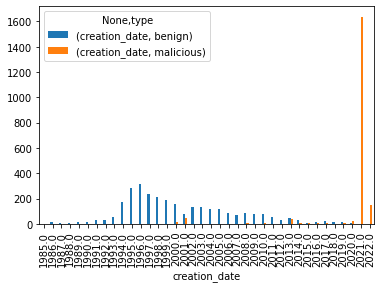

In [8]:
whois_df.groupby([whois_df['creation_date'].dt.year, 'type']).count().unstack('type').plot.bar()

In [9]:
# Create a new dataframe with old malicious domains
old_malicious_domains_df = whois_df[(whois_df['creation_date'] < '2021') & (whois_df['type'] == 'malicious')]
#print(old_malicious_domains_df)

# Root the domain, group, and review what concentrations exist.
old_malicious_domains_df = old_malicious_domains_df.reset_index().rename(columns={'index': 'domain_name'})
old_malicious_domains_df['root_domain'] = old_malicious_domains_df['domain_name'].apply(lambda x: '.'.join(get_domain_parts(x)[1:]))
old_malicious_domains_df.groupby('root_domain')['domain_name'].count().sort_values(ascending=False).head(10)

root_domain
ddns.net         38
duckdns.org      26
hopto.org        12
nsupdate.info    10
camdvr.org        4
dvrlists.com      4
zapto.org         4
azureedge.net     3
publicvm.com      2
workers.dev       2
Name: domain_name, dtype: int64

All 10 of the top used "old" malicious domains are shared (e.g., DDNS). 

In [10]:
# Load a maintained list of DDNS domains. Will not contain all shared domains, but will contain a lot of the dynamic providers.
# Known avialable options
# https://github.com/neu5ron/dynamic_dns_lists # Missing a lot of the domains
# https://github.com/stamparm/maltrail/blob/master/trails/static/suspicious/dynamic_domain.txt

ddns_domain_list_url = 'https://raw.githubusercontent.com/stamparm/maltrail/master/trails/static/suspicious/dynamic_domain.txt'

ddns_url_response = requests.get(ddns_domain_list_url, verify = False).content
shared_domains_df = pd.read_csv(io.StringIO(ddns_url_response.decode('utf-8')), comment='#', header=None)
shared_domains_df.rename(columns={0: "shared_domain_name"}, inplace=True)

# Add other known shared domains to DataFrame
other_shared_domains = ['azureedge.net', 'amazonaws.com']
shared_domains_df = shared_domains_df.append(pd.DataFrame(other_shared_domains, columns=['shared_domain_name'])).reset_index().drop(columns="index")
shared_domains_df

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'raw.githubusercontent.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/var/folders/zk/_l6jn98j1ws6ndxrzcw2dh4m0000gn/T/ipykernel_72185/2515696093.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  shared_domains_df = shared_domains_df.append(pd.DataFrame(other_shared_domains, columns=['shared_domain_name'])).reset_index().drop(columns="index")


,shared_domain_name
0,10dv.com
1,3utilities.com
2,abledns.com
3,abmetalmecanica.com
4,activewaiting.com
...,...
2324,4nmn.com
2325,didns.ru
2326,dynnamn.ru
2327,azureedge.net


In [11]:
old_malicious_not_shared_domains_df = old_malicious_domains_df[~old_malicious_domains_df['root_domain'].isin(shared_domains_df['shared_domain_name'])]

# Number of "old" malicious domains that exist after filtering out known shared domains.
len(old_malicious_not_shared_domains_df)

45

## Observations
* ~~Need to consider shared domains (e.g., ddns.net) when using age to determine likelihood that domain was registered for malicious purposes.~~
* A large number of malicious domains are new.
* Need to add a feature for "is_shared_domain".

# DNS Resolution Data EDA

In [12]:
data_file_dict['malicious_dns_resolution_data.txt'][0]

{'reseptors.com': {'A': {'IP': '164.90.204.224', 'Count': 1},
  'MX': {'IP': 'NA', 'Count': 0}}}

In [13]:
# Load data into dataframe, add type column, and merge
benign_dns_resolution_data = data_file_dict['benign_dns_resolution_data.txt']
malicious_dns_resolution_data = data_file_dict['malicious_dns_resolution_data.txt']

reformed_benign_dns_resolution_dict = {}
for dns_resolution_dict in benign_dns_resolution_data:
    for outerKey, innerDict in dns_resolution_dict.items():
        for innerKey, values in innerDict.items():
            reformed_benign_dns_resolution_dict[(outerKey, innerKey)] = values

benign_dns_resolution_df = pd.DataFrame(reformed_benign_dns_resolution_dict).T.stack().unstack(level=0).T
benign_dns_resolution_df['type'] = 'benign'

reformed_malicious_dns_resolution_dict = {}
for dns_resolution_dict in malicious_dns_resolution_data:
    for outerKey, innerDict in dns_resolution_dict.items():
        for innerKey, values in innerDict.items():
            reformed_malicious_dns_resolution_dict[(outerKey, innerKey)] = values

malicious_dns_resolution_df = pd.DataFrame(reformed_malicious_dns_resolution_dict).T.stack().unstack(level=0).T
malicious_dns_resolution_df['type'] = 'malicious'

dns_resolution_df = pd.concat([benign_dns_resolution_df, malicious_dns_resolution_df])

In [14]:
dns_resolution_df

A                   MX        \
                                       IP Count             IP Count   
000webhost.com             104.19.184.120     2  64.233.184.27     5   
000webhostapp.com            153.92.0.100     1  173.194.66.26     1   
1.bp.blogspot.com         142.250.191.161     1             NA     0   
123-reg-new-domain.co.uk               NA     0             NA     0   
12371.cn                  157.185.177.205     2             NA     0   
...                                   ...   ...            ...   ...   
zuwevex.com                            NA     0             NA     0   
zyokao27.top                           NA     0             NA     0   
zyonou41.top                           NA     0             NA     0   
zyoskv38.top                           NA     0             NA     0   
zyoyol62.top                           NA     0             NA     0   

                               type  
                                     
000webhost.com               benign  
000webhostapp.com            benign  
1.bp.blogspot.com            benign  
123-reg-new-domain.co.uk     benign  
12371.cn                     benign  
...                             ...  
zuwevex.com               malicious  
zyokao27.top              malicious  
zyonou41.top              malicious  
zyoskv38.top              malicious  
zyoyol62.top              malicious  

[6082 rows x 5 columns]

In [15]:
dns_resolution_df.groupby('type').describe()

A                                            MX             \
             IP                  Count                     IP              
          count unique top  freq count unique top  freq count unique top   
type                                                                       
benign     3687   2987  NA   182  3687     11   1  1836  3687   1271  NA   
malicious  2395    426  NA  1320  2395      6   0  1320  2395     52  NA   

                                        type                          
                Count                                                 
           freq count unique top  freq count unique        top  freq  
type                                                                  
benign      482  3687     16   1  1022  3687      1     benign  3687  
malicious  2283  2395      7   0  2275  2395      1  malicious  2395

In [16]:
# Top Benign A Record Counts
print(dns_resolution_df[dns_resolution_df['type'] == 'benign'].iloc[:, dns_resolution_df.columns.get_level_values(1)=='Count'][('A','Count')].value_counts().nlargest(5))
# Top Benign MX Record Counts
print(dns_resolution_df[dns_resolution_df['type'] == 'benign'].iloc[:, dns_resolution_df.columns.get_level_values(1)=='Count'][('MX','Count')].value_counts().nlargest(5))
# Top Malicious A Record Counts
print(dns_resolution_df[dns_resolution_df['type'] == 'malicious'].iloc[:, dns_resolution_df.columns.get_level_values(1)=='Count'][('A','Count')].value_counts().nlargest(5))
# Top Malicious MX Record Counts
print(dns_resolution_df[dns_resolution_df['type'] == 'malicious'].iloc[:, dns_resolution_df.columns.get_level_values(1)=='Count'][('MX','Count')].value_counts().nlargest(5))


1    1836
2     761
4     520
3     286
0     182
Name: (A, Count), dtype: int64
1    1022
2     896
5     783
0     441
4     176
Name: (MX, Count), dtype: int64
0     1320
1      972
2       97
10       4
4        1
Name: (A, Count), dtype: int64
0    2275
1      57
5      51
2       6
3       3
Name: (MX, Count), dtype: int64


## Observations
* 

# IP Data EDA

In [17]:
data_file_dict['benign_ip_data.txt'][0]

{'google.com': {'A': {'CC': 'US', 'Org': 'Google LLC'},
  'MX': {'CC': 'US', 'Org': 'Google LLC'}}}

In [18]:
# Load data into dataframe, add type column, and merge
benign_ip_data = data_file_dict['benign_ip_data.txt']
malicious_ip_data = data_file_dict['malicious_ip_data.txt']


reformed_benign_ip_dict = {}
for ip_dict in benign_ip_data:
    for outerKey, innerDict in ip_dict.items():
        for innerKey, values in innerDict.items():
            reformed_benign_ip_dict[(outerKey, innerKey)] = values

benign_ip_df = pd.DataFrame(reformed_benign_ip_dict).T.stack().unstack(level=0).T
benign_ip_df['type'] = 'benign'

reformed_malicious_ip_dict = {}
for ip_dict in malicious_ip_data:
    for outerKey, innerDict in ip_dict.items():
        for innerKey, values in innerDict.items():
            reformed_malicious_ip_dict[(outerKey, innerKey)] = values

malicious_ip_df = pd.DataFrame(reformed_malicious_ip_dict).T.stack().unstack(level=0).T
malicious_ip_df['type'] = 'malicious'

ip_df = pd.concat([benign_ip_df, malicious_ip_df])

In [19]:
ip_df

A                        MX                   type
                          CC                   Org  CC         Org           
000webhost.com            US      Cloudflare, Inc.  US  Google LLC     benign
000webhostapp.com         CY         Hostinger NOC  US  Google LLC     benign
1.bp.blogspot.com         US            Google LLC  NA          NA     benign
123-reg-new-domain.co.uk  NA                    NA  NA          NA     benign
12371.cn                  US  QUANTIL NETWORKS INC  NA          NA     benign
...                       ..                   ...  ..         ...        ...
zuwevex.com               NA                    NA  NA          NA  malicious
zyokao27.top              NA                    NA  NA          NA  malicious
zyonou41.top              NA                    NA  NA          NA  malicious
zyoskv38.top              NA                    NA  NA          NA  malicious
zyoyol62.top              NA                    NA  NA          NA  malicious

[6082 rows x 5 columns]

In [20]:
ip_df.groupby('type').describe()

A                                                          MX  \
             CC                    Org                                   CC   
          count unique top  freq count unique               top  freq count   
type                                                                          
benign     3687     51  US  2805  3687    848  Cloudflare, Inc.   445  3687   
malicious  2395     37  NA  1354  2395    147                NA  1354  2395   

                                                           type         \
                             Org                                         
          unique top  freq count unique         top  freq count unique   
type                                                                     
benign        48  US  2580  3687    549  Google LLC  1065  3687      1   
malicious     17  NA  2286  2395     38          NA  2286  2395      1   

                            
                            
                 top  freq  
type                        
benign        benign  3687  
malicious  malicious  2395

In [21]:
# Top Benign A Record Orgs
print(ip_df[ip_df['type'] == 'benign'].iloc[:, ip_df.columns.get_level_values(1)=='Org'][('A','Org')].value_counts().nlargest(5))
# Top Benign MX Record Orgs
print(ip_df[ip_df['type'] == 'benign'].iloc[:, ip_df.columns.get_level_values(1)=='Org'][('MX','Org')].value_counts().nlargest(5))
# Top Malicious A Record Orgs
print(ip_df[ip_df['type'] == 'malicious'].iloc[:, ip_df.columns.get_level_values(1)=='Org'][('A','Org')].value_counts().nlargest(5))
# Top Malicious MX Record Orgs
print(ip_df[ip_df['type'] == 'malicious'].iloc[:, ip_df.columns.get_level_values(1)=='Org'][('MX','Org')].value_counts().nlargest(5))


Cloudflare, Inc.            445
Amazon.com, Inc.            328
NA                          294
Fastly                      254
Amazon Technologies Inc.    251
Name: (A, Org), dtype: int64
Google LLC                         1065
NA                                  586
Microsoft Corporation               543
Proofpoint, Inc.                    322
Cisco Systems Ironport Division      78
Name: (MX, Org), dtype: int64
NA                  1354
REGRU-MNT            292
Linode               191
Cloudflare, Inc.      92
OVH GmbH              88
Name: (A, Org), dtype: int64
NA                          2286
Namecheap, Inc.               50
Oath Holdings Inc.            11
Stop the war in Ukraine!       6
PSINet, Inc.                   3
Name: (MX, Org), dtype: int64


In [22]:
# Top Benign A Record Locations
print(ip_df[ip_df['type'] == 'benign'].iloc[:, ip_df.columns.get_level_values(1)=='CC'][('A','CC')].value_counts().nlargest(10))
# Top Benign MX Record Locations
print(ip_df[ip_df['type'] == 'benign'].iloc[:, ip_df.columns.get_level_values(1)=='CC'][('MX','CC')].value_counts().nlargest(10))
# Top Malicious A Record Locations
print(ip_df[ip_df['type'] == 'malicious'].iloc[:, ip_df.columns.get_level_values(1)=='CC'][('A','CC')].value_counts().nlargest(10))
# Top Malicious MX Record Locations
print(ip_df[ip_df['type'] == 'malicious'].iloc[:, ip_df.columns.get_level_values(1)=='CC'][('MX','CC')].value_counts().nlargest(10))


US    2805
NA     291
CN      85
DE      80
GB      58
FR      56
RU      49
CA      47
NL      36
CH      25
Name: (A, CC), dtype: int64
US    2580
NA     586
GB      90
DE      81
CN      75
RU      41
FR      35
CA      31
CH      17
NL      15
Name: (MX, CC), dtype: int64
NA    1354
US     489
RU     335
FR      94
NL      20
DE      12
RO      12
LT       6
BG       6
NZ       6
Name: (A, CC), dtype: int64
NA    2286
US      82
NL       6
DE       4
RU       4
NG       2
DZ       1
GR       1
UA       1
IR       1
Name: (MX, CC), dtype: int64


In [23]:
#url = 'https://gist.github.com/tadast/8827699' #alternative option
url = 'https://gist.githubusercontent.com/metal3d/5b925077e66194551df949de64e910f6/raw/c5f20a037409d96958553e2eb6b8251265c6fd63/country-coord.csv'
response = requests.get(url, verify = False).content
coordinates_df = pd.read_csv(io.StringIO(response.decode('utf-8')))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gist.githubusercontent.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [24]:
coordinates_df

,Country,Alpha-2 code,Alpha-3 code,Numeric code,Latitude (average),Longitude (average)
0,Afghanistan,AF,AFG,4,33.0000,65.0
1,Albania,AL,ALB,8,41.0000,20.0
2,Algeria,DZ,DZA,12,28.0000,3.0
3,American Samoa,AS,ASM,16,-14.3333,-170.0
4,Andorra,AD,AND,20,42.5000,1.6
...,...,...,...,...,...,...
239,Wallis and Futuna,WF,WLF,876,-13.3000,-176.2
240,Western Sahara,EH,ESH,732,24.5000,-13.0
241,Yemen,YE,YEM,887,15.0000,48.0
242,Zambia,ZM,ZMB,894,-15.0000,30.0


In [25]:
# Create two dataframes, one for each record type
# Then join with coordinates_df
ip_loc_df = ip_df.copy()
ip_loc_df.columns = ip_loc_df.columns.droplevel()
ip_loc_df = ip_loc_df.drop(columns='Org')
ip_loc_df.columns = ['CC_A', 'CC_MX', 'type']
ip_loc_A_df = ip_loc_df.reset_index().drop(columns=['index', 'CC_MX'])
ip_loc_A_df  = ip_loc_A_df[ip_loc_A_df['CC_A'].isin(['NA']) == False]
ip_loc_A_df = ip_loc_A_df.merge(coordinates_df, left_on='CC_A', right_on='Alpha-2 code')
ip_loc_MX_df = ip_loc_df.reset_index().drop(columns=['index', 'CC_A'])
ip_loc_MX_df  = ip_loc_MX_df[ip_loc_MX_df['CC_MX'].isin(['NA']) == False]
ip_loc_MX_df = ip_loc_MX_df.merge(coordinates_df, left_on='CC_MX', right_on='Alpha-2 code')

## Heat Map

In [26]:
benign_ip_locs_A = ip_loc_A_df[ip_loc_A_df['type'] == 'benign'][['Latitude (average)', 'Longitude (average)']]
malicious_ip_locs_A = ip_loc_A_df[ip_loc_A_df['type'] == 'malicious'][['Latitude (average)', 'Longitude (average)']]
benign_ip_locs_MX = ip_loc_MX_df[ip_loc_MX_df['type'] == 'benign'][['Latitude (average)', 'Longitude (average)']]
malicious_ip_locs_MX = ip_loc_MX_df[ip_loc_MX_df['type'] == 'malicious'][['Latitude (average)', 'Longitude (average)']]


heatmap = folium.Map(location=[ip_loc_A_df['Latitude (average)'].mean(), ip_loc_A_df['Longitude (average)'].mean()],
                 zoom_start=2, control_scale=True)

f_A_benign = folium.FeatureGroup("Benign A Records")
f_A_malicious = folium.FeatureGroup("Malicious A Records")
f_MX_benign = folium.FeatureGroup("Benign MX Records")
f_MX_malicious = folium.FeatureGroup("Malicious MX Records")

f_A_benign.add_to(heatmap)
f_A_malicious.add_to(heatmap)
f_MX_benign.add_to(heatmap)
f_MX_malicious.add_to(heatmap)

plugins.HeatMap(benign_ip_locs_A, radius=25).add_to(f_A_benign)
plugins.HeatMap(malicious_ip_locs_A, radius=25).add_to(f_A_malicious)
plugins.HeatMap(benign_ip_locs_MX, radius=25).add_to(f_MX_benign)
plugins.HeatMap(malicious_ip_locs_MX, radius=25).add_to(f_MX_malicious)

folium.LayerControl().add_to(heatmap)

heatmap


## Observations
* Very high number of malicious domains were unresolvable (likely due to being queried so far after the whois list was generated).
* With the malicious domains that were resolvable, a large number did not have an MX record.

# Entropy Data EDA

In [27]:
# DGA Primer: https://jason-trost.medium.com/getting-started-with-dga-domain-detection-research-89af69213257

In [28]:
data_file_dict['benign_entropy_data.txt'][0]

{'google.com': 1.9182958340544893}

In [29]:
# Load data into dataframe, add type column, and merge
benign_entropy_data = data_file_dict['benign_entropy_data.txt']
malicious_entropy_data = data_file_dict['malicious_entropy_data.txt']

benign_entropy_df = pd.DataFrame.from_dict(ChainMap(*benign_entropy_data), orient='index', columns=['entropy_value'])
benign_entropy_df['type'] = 'benign'
malicious_entropy_df = pd.DataFrame.from_dict(ChainMap(*malicious_entropy_data), orient='index', columns=['entropy_value'])
malicious_entropy_df['type'] = 'malicious'
entropy_df = pd.concat([benign_entropy_df, malicious_entropy_df])

In [30]:
entropy_df

,entropy_value,type
canadiantire.ca,2.855389,benign
sch.gr,1.584963,benign
torgi.gov.ru,2.500000,benign
htc.com,1.584963,benign
adaa.org,0.811278,benign
...,...,...
crmweb.info,2.584963,malicious
eleccom.shop,2.235926,malicious
izocab.com,2.584963,malicious
contentcdns.net,2.663533,malicious


In [31]:
entropy_df.groupby('type')['entropy_value'].describe()

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
benign,3687.0,2.372359,0.738613,0.0,1.921928,2.521641,2.921928,3.879664
malicious,2395.0,3.068759,0.479918,0.0,2.750000,3.039149,3.412270,4.395999


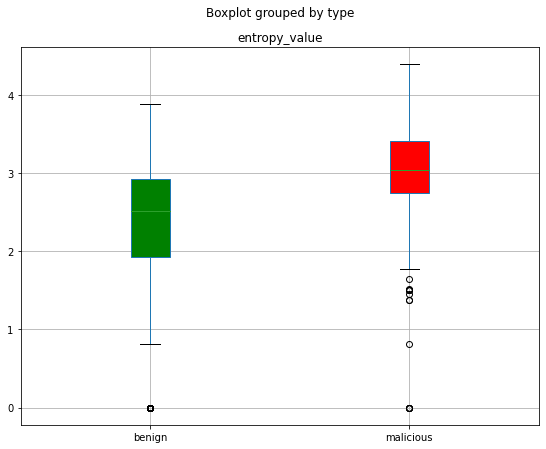

In [32]:
plt.rcParams["figure.figsize"] = [9, 7]
entropy_plot = entropy_df.boxplot(by='type', figsize=(9, 7), return_type='both',
    patch_artist = True)
colors = ['g', 'r']
for row_key, (ax,row) in entropy_plot.iteritems():
    ax.set_xlabel('')
    for i,box in enumerate(row['boxes']):
        box.set_facecolor(colors[i])
plt.show()

In [33]:
entropy_df[entropy_df['entropy_value']<=0.1]

,entropy_value,type
ind.br,0.0,benign
www.gov.pl,-0.0,benign
adv.br,0.0,benign
or.ke,0.0,benign
ga.us,0.0,benign
...,...,...
idv.tw,0.0,malicious
mmmmmm.casa,-0.0,malicious
mmmmmm.bar,-0.0,malicious
nnnnnn.casa,-0.0,malicious


### Todo: Need to look into why some domains have entropy values of zero. Possibly mistaken as TLD's.

# Misc

In [87]:
benign_domain_list = []
for benign_domain_whois in data_file_dict['benign_whois_data.txt']:
    benign_domain_list.append(list(benign_domain_whois.keys())[0])
benign_domain_without_tld_dict = {}
for benign_domain_name in benign_domain_list:
    domain_parts = get_domain_parts(benign_domain_name)[:2]
    benign_domain_without_tld_dict[benign_domain_name] = [''.join(domain_parts[:2])]
benign_domain_df = pd.DataFrame.from_dict(benign_domain_without_tld_dict).T.rename(columns={0: 'domain'})
benign_domain_df['type'] = 'benign'
benign_domain_df['length']= benign_domain_df['domain'].str.len()
print("Benign Domains:")
print("Average length (without TLD): " + str(benign_domain_df['domain'].apply(len).mean()))
print("\n")

malicious_domain_list = []
for malicious_domain_whois in data_file_dict['malicious_whois_data.txt']:
    malicious_domain_list.append(list(malicious_domain_whois.keys())[0])
malicious_domain_without_tld_dict = {}
for malicious_domain_name in malicious_domain_list:
    domain_parts = get_domain_parts(malicious_domain_name)[:2]
    malicious_domain_without_tld_dict[malicious_domain_name] = [''.join(domain_parts[:2])]
malicious_domain_df = pd.DataFrame.from_dict(malicious_domain_without_tld_dict).T.rename(columns={0: 'domain'})
malicious_domain_df['type'] = 'malicious'
malicious_domain_df['length']= malicious_domain_df['domain'].str.len()
print("Malicious Domains:")
print("Average length (without TLD): " + str(malicious_domain_df['domain'].apply(len).mean()))

# Combine DataFrames
domain_df = pd.concat([benign_domain_df, malicious_domain_df])
    

Benign Domains:
Average length (without TLD): 7.419039869812856


Malicious Domains:
Average length (without TLD): 12.99206680584551


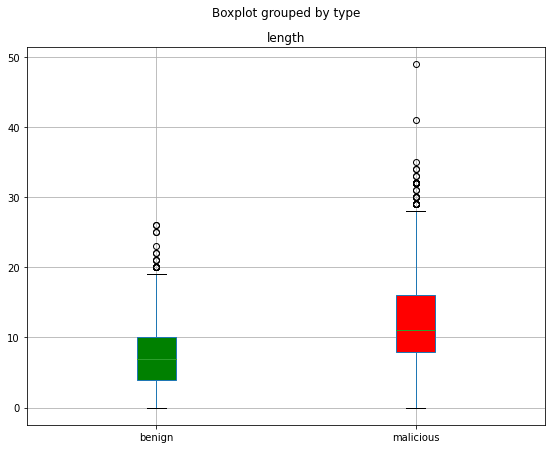

In [88]:
plt.rcParams["figure.figsize"] = [9, 7]
domain_plot = domain_df.boxplot(by='type', figsize=(9, 7), return_type='both',
    patch_artist = True)
colors = ['g', 'r']
for row_key, (ax,row) in domain_plot.iteritems():
    ax.set_xlabel('')
    for i,box in enumerate(row['boxes']):
        box.set_facecolor(colors[i])
plt.show()

https://github.com/exp0se/dga_detector

Interestingly, this project uses ngram analysis + length, consonants, entropy thresholds. 
We've already looked at length and entropy, let's look at the other items next.

In [89]:
# Look at consonant count
def count_consonants(domain):
    consonant_count = 0
    for i in range(0,len(domain)):
        if domain[i] not in ('a',"e","i","o","u"):  
            consonant_count = consonant_count + 1
    return consonant_count

domain_df['consonants'] = domain_df['domain'].apply(lambda x: count_consonants(x))
domain_df

,domain,type,length,consonants
google.com,google,benign,6,3
facebook.com,facebook,benign,8,4
youtube.com,youtube,benign,7,3
twitter.com,twitter,benign,7,5
instagram.com,instagram,benign,9,6
...,...,...,...,...
ewakyc72.top,ewakyc72,malicious,8,6
ewazqx71.top,ewazqx71,malicious,8,6
rebornx.duckdns.org,rebornxduckdns,malicious,14,11
mail.dipiluminacion.com,maildipiluminacion,malicious,18,9


https://datadrivensecurity.info/blog/posts/2014/Oct/dga-part2/
https://datadrivensecurity.info/blog/posts/2014/Oct/dga-part3/

Great reference on generating features to detect DGA's.

In [108]:
# Add entropy
combined_domain_df = domain_df.join(entropy_df, lsuffix='_domain', rsuffix='_entropy').drop(columns='type_entropy').rename(columns={'type_domain': 'type'})
combined_domain_df = combined_domain_df.join(whois_df, lsuffix='_domain', rsuffix='_whois').drop(columns=['type_whois', 'creation_date']).rename(columns={'type_domain': 'type'})
combined_domain_df

,domain,type,length,consonants,entropy_value,domain_age
000webhost.com,000webhost,benign,10,8,2.846439,14.0
000webhostapp.com,000webhostapp,benign,13,10,3.180833,5.0
0axqpcc.cn,0axqpcc,malicious,7,6,2.521641,0.0
0ffline.offes.co.uk,0fflineoffes,malicious,12,8,2.751629,25.0
0jaest.calipol.top,0jaestcalipol,malicious,13,8,3.392747,0.0
...,...,...,...,...,...,...
zuwevex.com,zuwevex,malicious,7,4,2.521641,0.0
zyokao27.top,zyokao27,malicious,8,5,2.750000,0.0
zyonou41.top,zyonou41,malicious,8,5,2.750000,0.0
zyoskv38.top,zyoskv38,malicious,8,7,3.000000,0.0


/var/folders/zk/_l6jn98j1ws6ndxrzcw2dh4m0000gn/T/ipykernel_72185/109567833.py:3: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  boxplot_dict = combined_domain_df.boxplot(


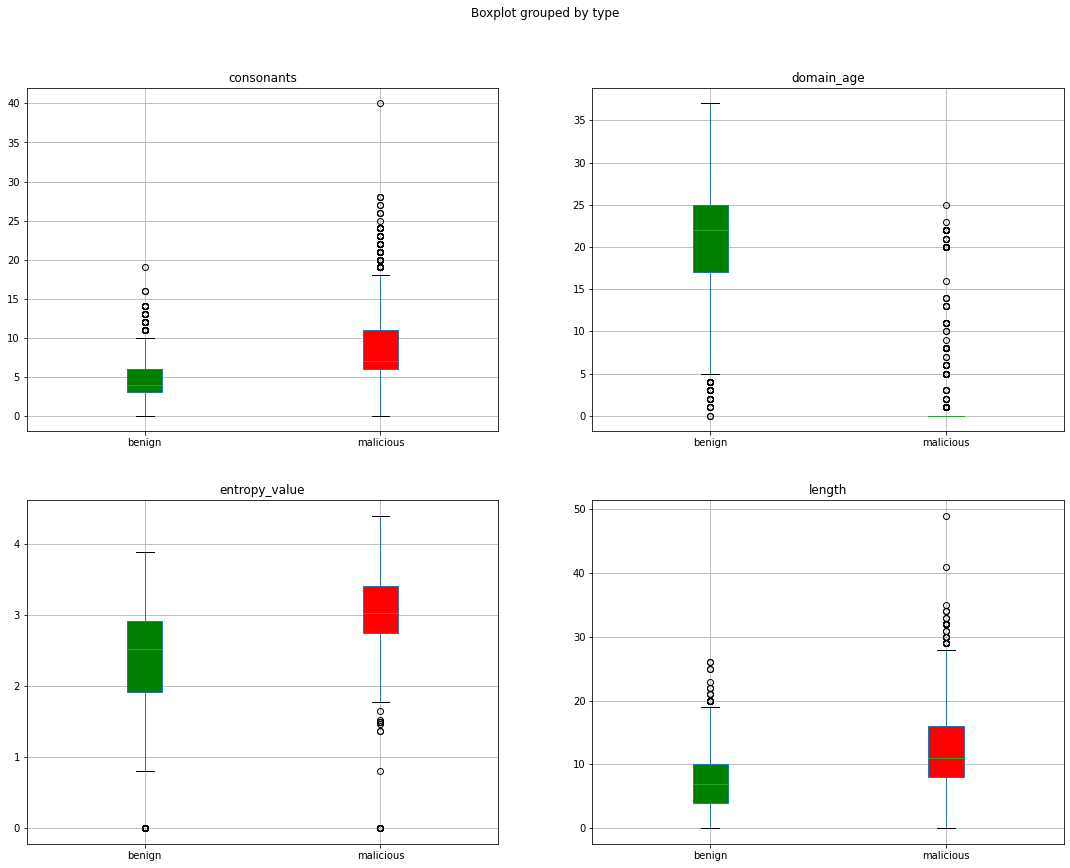

In [143]:
fig, axes = plt.subplots(2,2,sharex=False,sharey=False)

boxplot_dict = combined_domain_df.boxplot(
    by="type", ax=axes, figsize=(6,4),
    return_type='both',
    patch_artist = True
)

colors = ['g', 'r']
for row_key, (ax,row) in boxplot_dict.iteritems():
    ax.set_xlabel('')
    for i,box in enumerate(row['boxes']):
        box.set_facecolor(colors[i])
plt.show()

In [114]:
quantile_value = 0.75
entropy_threshold = combined_domain_df[combined_domain_df['type'] == 'benign']['entropy_value'].quantile(quantile_value) 
consonants_threshold = combined_domain_df[combined_domain_df['type'] == 'benign']['consonants'].quantile(quantile_value) 
length_threshold = combined_domain_df[combined_domain_df['type'] == 'benign']['length'].quantile(quantile_value) 
# We will use 1-quantile_value to look at the younger side versus the older side, with the assumption that newer domains are more likely to be DGAs.
age_threshold = combined_domain_df[combined_domain_df['type'] == 'benign']['domain_age'].quantile(1 - quantile_value) 

print("quantile for threshold: " + str(quantile_value))
print("entropy threshold: " + str(entropy_threshold))
print("consonants threshold: " + str(consonants_threshold))
print("length threshold: " + str(length_threshold))
print("age threshold: " + str(age_threshold))


quantile for threshold: 0.75
entropy threshold: 2.9219280948873623
consonants threshold: 6.0
length threshold: 10.0
age threshold: 17.0


In [150]:
# Look at filtered results
filtered_dga_domain_df = combined_domain_df[(combined_domain_df['type'] == 'malicious') & (combined_domain_df['length'] > length_threshold) & (combined_domain_df['entropy_value'] > entropy_threshold) & (combined_domain_df['consonants'] > consonants_threshold) \
                            & (combined_domain_df['domain_age'] < age_threshold)]
print(len(filtered_dga_domain_df))
print(filtered_dga_domain_df.index.tolist())

855
['0jaest.calipol.top', '11.bmesarsodothmqoubieo.com', '194-58-108-89.cloudvps.regruhosting.ru', '2t2ev5giwktc5o9.quest', '3f2ocy9clt90x74.one', '3info.medicalbankform.com', '4auahb.calitin.buzz', '4kaier.calipol.top', '5pneuovxi22i4fagh9.today', '6v2mofchw2eix98.quest', '7861f5b56aa4.xyz', '9wlmskjvkk.execute-api.us-east-1.amazonaws.com', 'a575hh752dp9l6c.one', 'accessunited-bank.com', 'acerthk3v9fvsby5n.today', 'actuallyobligat.info', 'actuallyobligat.ink', 'ad-postback.biz', 'adjacentlim.top', 'administrators.bmesarsodothmqoubieo.com', 'adobeacrobatupdate.com', 'adobeacrobatupdater.com', 'af.bmesarsodothmqoubieo.com', 'agent.apacheorg.top', 'agent.apacheorg.xyz', 'airportslim.top', 'alessandroknights3434.top', 'allisonshyg.com', 'amarilloporeder.pw', 'amasacdddorjbreisgihduhicfeoiapu.shop', 'amechi.duckdns.org', 'ancjrljxpmegbstgwrxo.com', 'announcements.bmesarsodothmqoubieo.com', 'anofauhlxfjumbieoakk.com', 'answersfromtheadvisors.com', 'antiquefund1998b.com', 'anz1guftr2hdaqq3w

In [154]:
# Create list of n-grams per domain.
n=4
combined_domain_df['ngrams'] = combined_domain_df['domain'].apply(lambda x: [x[i:i+n] for i in range(len(x)-n+1)])
combined_domain_df['ngrams']

000webhost.com                [000w, 00we, 0web, webh, ebho, bhos, host]
000webhostapp.com      [000w, 00we, 0web, webh, ebho, bhos, host, ost...
0axqpcc.cn                                      [0axq, axqp, xqpc, qpcc]
0ffline.offes.co.uk    [0ffl, ffli, flin, line, ineo, neof, eoff, off...
0jaest.calipol.top     [0jae, jaes, aest, estc, stca, tcal, cali, ali...
                                             ...                        
zuwevex.com                                     [zuwe, uwev, weve, evex]
zyokao27.top                              [zyok, yoka, okao, kao2, ao27]
zyonou41.top                              [zyon, yono, onou, nou4, ou41]
zyoskv38.top                              [zyos, yosk, oskv, skv3, kv38]
zyoyol62.top                              [zyoy, yoyo, oyol, yol6, ol62]
Name: ngrams, Length: 6088, dtype: object

In [157]:
#Download majestic million list
#majestic_million_domains_url = 'http://downloads.majestic.com/majestic_million.csv'
#urllib.request.urlretrieve(majestic_million_domains_url, '/Users/kgray/Downloads/majestic_million.csv')

('/Users/kgray/Downloads/majestic_million.csv',
 <http.client.HTTPMessage at 0x2997cd6f0>)

Another great reference: https://github.com/SuperCowPowers/data_hacking/blob/master/dga_detection/DGA_Domain_Detection.ipynb

Text(0, 0.5, 'Domain Entropy')

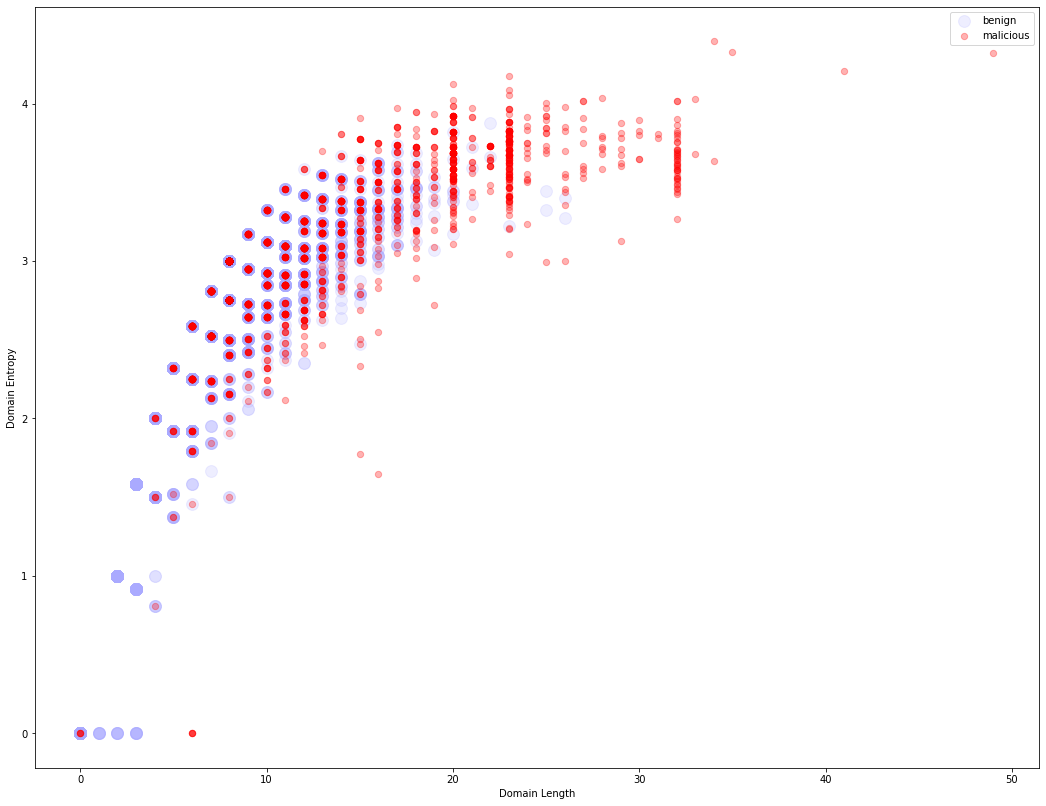

In [164]:
plt.scatter(combined_domain_df[combined_domain_df['type'] == 'benign']['length'], combined_domain_df[combined_domain_df['type'] == 'benign']['entropy_value'], s=140, c='#aaaaff', label='benign', alpha=.2)
plt.scatter(combined_domain_df[combined_domain_df['type'] == 'malicious']['length'], combined_domain_df[combined_domain_df['type'] == 'malicious']['entropy_value'], s=40, c='r', label='malicious', alpha=.3)
plt.legend()
pylab.xlabel('Domain Length')
pylab.ylabel('Domain Entropy')

Text(0, 0.5, 'Domain Entropy')

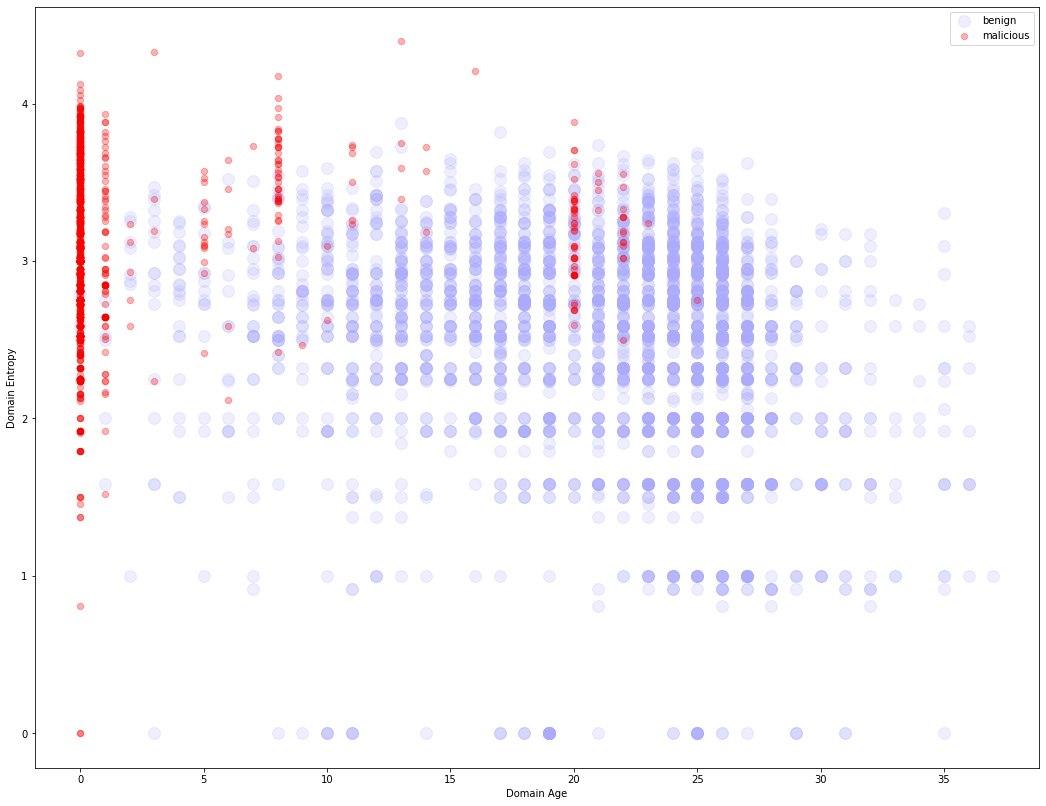

In [163]:
plt.scatter(combined_domain_df[combined_domain_df['type'] == 'benign']['domain_age'], combined_domain_df[combined_domain_df['type'] == 'benign']['entropy_value'], s=140, c='#aaaaff', label='benign', alpha=.2)
plt.scatter(combined_domain_df[combined_domain_df['type'] == 'malicious']['domain_age'], combined_domain_df[combined_domain_df['type'] == 'malicious']['entropy_value'], s=40, c='r', label='malicious', alpha=.3)
plt.legend()
pylab.xlabel('Domain Age')
pylab.ylabel('Domain Entropy')

## Consider the number of English dictionary words in each domain

In [256]:
word_list = set(words.words())
word_length_threshold = 3
# Remove words with less than 4 characters
word_list = [x for x in word_list if len(x) > word_length_threshold ]

# Todo: Stop searching when domain becomes all numbers or spaces
# Search for words in domain string. Remove the words from the domain when a match occurs,
# otherwise we could have more word characters in a domain than the length of a string.
# Should consider that shorter words may match first simply due to coming first in
# the dictionary. How can we account for that?
def find_words(domain, word_list, verbose=False):
    word_count = 0
    for word in word_list:
        if word in domain:
            word_count += len(word)
            domain = domain.replace(word, ' ')
            if verbose: print(word + " matched in " + domain)
            if verbose: print("updated domain is now " + domain)
    return(word_count)

In [257]:
# Test function to make sure it works as expected
# Result should be a cumulative count of the letters that make up words
print(find_words("000webhost", word_list, verbose=True))
print(find_words("microsoft", word_list, verbose=True))

host matched in 000web 
updated domain is now 000web 
4
micro matched in  soft
updated domain is now  soft
soft matched in   
updated domain is now   
9


In [258]:
combined_domain_df['word_count'] = combined_domain_df['domain'].apply(lambda x: find_words(x, word_list))

In [259]:
combined_domain_df

,domain,type,length,consonants,entropy_value,domain_age,ngrams,word_count,word_ratio
000webhost.com,000webhost,benign,10,8,2.846439,14.0,"[000w, 00we, 0web, webh, ebho, bhos, host]",4,0.400000
000webhostapp.com,000webhostapp,benign,13,10,3.180833,5.0,"[000w, 00we, 0web, webh, ebho, bhos, host, ost...",4,0.615385
0axqpcc.cn,0axqpcc,malicious,7,6,2.521641,0.0,"[0axq, axqp, xqpc, qpcc]",0,0.000000
0ffline.offes.co.uk,0fflineoffes,malicious,12,8,2.751629,25.0,"[0ffl, ffli, flin, line, ineo, neof, eoff, off...",4,0.333333
0jaest.calipol.top,0jaestcalipol,malicious,13,8,3.392747,0.0,"[0jae, jaes, aest, estc, stca, tcal, cali, ali...",0,0.000000
...,...,...,...,...,...,...,...,...,...
zuwevex.com,zuwevex,malicious,7,4,2.521641,0.0,"[zuwe, uwev, weve, evex]",4,0.571429
zyokao27.top,zyokao27,malicious,8,5,2.750000,0.0,"[zyok, yoka, okao, kao2, ao27]",0,0.000000
zyonou41.top,zyonou41,malicious,8,5,2.750000,0.0,"[zyon, yono, onou, nou4, ou41]",0,0.000000
zyoskv38.top,zyoskv38,malicious,8,7,3.000000,0.0,"[zyos, yosk, oskv, skv3, kv38]",0,0.000000


In [260]:
combined_domain_df.groupby('type')['word_count'].describe()

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
benign,3690.0,4.187263,3.963154,0.0,0.0,4.0,7.0,22.0
malicious,2398.0,3.784404,4.018498,0.0,0.0,4.0,6.0,25.0


word_count    (AxesSubplot(0.1,0.15;0.8x0.75), {'whiskers': ...
dtype: object

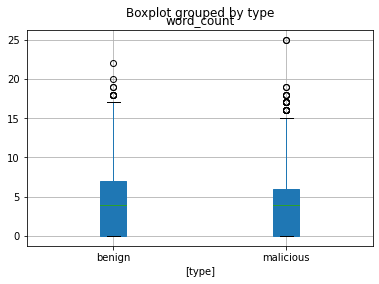

In [261]:
combined_domain_df[['type', 'word_count']].boxplot(
    by="type", figsize=(6,4),
    return_type='both',
    patch_artist = True
)

In [262]:
combined_domain_df['word_ratio'] = combined_domain_df['word_count'] / combined_domain_df['length']

In [263]:
combined_domain_df

,domain,type,length,consonants,entropy_value,domain_age,ngrams,word_count,word_ratio
000webhost.com,000webhost,benign,10,8,2.846439,14.0,"[000w, 00we, 0web, webh, ebho, bhos, host]",4,0.400000
000webhostapp.com,000webhostapp,benign,13,10,3.180833,5.0,"[000w, 00we, 0web, webh, ebho, bhos, host, ost...",4,0.307692
0axqpcc.cn,0axqpcc,malicious,7,6,2.521641,0.0,"[0axq, axqp, xqpc, qpcc]",0,0.000000
0ffline.offes.co.uk,0fflineoffes,malicious,12,8,2.751629,25.0,"[0ffl, ffli, flin, line, ineo, neof, eoff, off...",4,0.333333
0jaest.calipol.top,0jaestcalipol,malicious,13,8,3.392747,0.0,"[0jae, jaes, aest, estc, stca, tcal, cali, ali...",0,0.000000
...,...,...,...,...,...,...,...,...,...
zuwevex.com,zuwevex,malicious,7,4,2.521641,0.0,"[zuwe, uwev, weve, evex]",4,0.571429
zyokao27.top,zyokao27,malicious,8,5,2.750000,0.0,"[zyok, yoka, okao, kao2, ao27]",0,0.000000
zyonou41.top,zyonou41,malicious,8,5,2.750000,0.0,"[zyon, yono, onou, nou4, ou41]",0,0.000000
zyoskv38.top,zyoskv38,malicious,8,7,3.000000,0.0,"[zyos, yosk, oskv, skv3, kv38]",0,0.000000


In [264]:
combined_domain_df.groupby('type')['word_ratio'].describe()

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
benign,3610.0,0.465409,0.378776,0.0,0.0,0.555556,0.800000,1.0
malicious,2394.0,0.295958,0.294891,0.0,0.0,0.307692,0.529412,1.0


word_ratio    (AxesSubplot(0.1,0.15;0.8x0.75), {'whiskers': ...
dtype: object

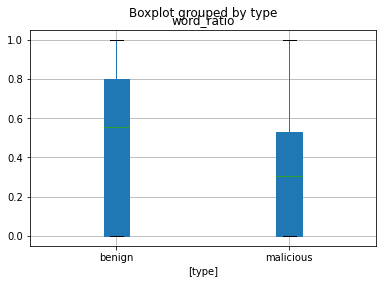

In [265]:
combined_domain_df[['type', 'word_ratio']].boxplot(
    by="type", figsize=(6,4),
    return_type='both',
    patch_artist = True
)

In [293]:
# Reproduce masked n-gram idea found in https://webdiis.unizar.es/~ricardo/files/papers/SRS-ESWA-19.pdf.
# Todo: Ensure we're not missing any character types.
# n = number; s = symbol; v = vowel, c = consonant
def mask_string(domain):
    symbols = ("-")
    vowels = ("a","e","i","o","u")
    masked_domain = []
    for i in range(0,len(domain)):
        masked_value = ""
        if domain[i].isnumeric():
            masked_value = "n"
        elif domain[i] in symbols:  
            masked_value = "s"
        elif domain[i] in vowels:  
            masked_value = "v"
        else:  
            masked_value = "c"
        masked_domain.append(masked_value)
    return ''.join(masked_domain)

In [295]:
print(mask_string("test123-4"))

cvccnnnsn


In [291]:
combined_domain_df['masked_domain'] = combined_domain_df['domain'].apply(lambda x: mask_string(x))
combined_domain_df

,domain,type,length,consonants,entropy_value,domain_age,ngrams,word_count,word_ratio,masked_domain
000webhost.com,000webhost,benign,10,8,2.846439,14.0,"[000w, 00we, 0web, webh, ebho, bhos, host]",4,0.400000,nnncvccvcc
000webhostapp.com,000webhostapp,benign,13,10,3.180833,5.0,"[000w, 00we, 0web, webh, ebho, bhos, host, ost...",4,0.307692,nnncvccvccvcc
0axqpcc.cn,0axqpcc,malicious,7,6,2.521641,0.0,"[0axq, axqp, xqpc, qpcc]",0,0.000000,nvccccc
0ffline.offes.co.uk,0fflineoffes,malicious,12,8,2.751629,25.0,"[0ffl, ffli, flin, line, ineo, neof, eoff, off...",4,0.333333,ncccvcvvccvc
0jaest.calipol.top,0jaestcalipol,malicious,13,8,3.392747,0.0,"[0jae, jaes, aest, estc, stca, tcal, cali, ali...",0,0.000000,ncvvcccvcvcvc
...,...,...,...,...,...,...,...,...,...,...
zuwevex.com,zuwevex,malicious,7,4,2.521641,0.0,"[zuwe, uwev, weve, evex]",4,0.571429,cvcvcvc
zyokao27.top,zyokao27,malicious,8,5,2.750000,0.0,"[zyok, yoka, okao, kao2, ao27]",0,0.000000,ccvcvvnn
zyonou41.top,zyonou41,malicious,8,5,2.750000,0.0,"[zyon, yono, onou, nou4, ou41]",0,0.000000,ccvcvvnn
zyoskv38.top,zyoskv38,malicious,8,7,3.000000,0.0,"[zyos, yosk, oskv, skv3, kv38]",0,0.000000,ccvcccnn


In [312]:
# Create list of masked n-grams per domain.
n=4
combined_domain_df['masked_ngrams'] = combined_domain_df['masked_domain'].apply(lambda x: [x[i:i+n] for i in range(len(x)-n+1)])
combined_domain_df['masked_ngrams']

000webhost.com                [nnnc, nncv, ncvc, cvcc, vccv, ccvc, cvcc]
000webhostapp.com      [nnnc, nncv, ncvc, cvcc, vccv, ccvc, cvcc, vcc...
0axqpcc.cn                                      [nvcc, vccc, cccc, cccc]
0ffline.offes.co.uk    [nccc, cccv, ccvc, cvcv, vcvv, cvvc, vvcc, vcc...
0jaest.calipol.top     [ncvv, cvvc, vvcc, vccc, cccv, ccvc, cvcv, vcv...
                                             ...                        
zuwevex.com                                     [cvcv, vcvc, cvcv, vcvc]
zyokao27.top                              [ccvc, cvcv, vcvv, cvvn, vvnn]
zyonou41.top                              [ccvc, cvcv, vcvv, cvvn, vvnn]
zyoskv38.top                              [ccvc, cvcc, vccc, cccn, ccnn]
zyoyol62.top                              [ccvc, cvcv, vcvc, cvcn, vcnn]
Name: masked_ngrams, Length: 6088, dtype: object

In [313]:
#combined_domain_df['masked_ngrams'].explode()

mlb = MultiLabelBinarizer(sparse_output=True)

combined_domain_df = combined_domain_df.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(combined_domain_df.pop('masked_ngrams')),
                index=combined_domain_df.index,
                columns=mlb.classes_))

In [314]:
combined_domain_dfdd

,domain,type,length,consonants,entropy_value,domain_age,ngrams,word_count,word_ratio,masked_domain,...,vvcs,vvcv,vvnc,vvnn,vvnv,vvsc,vvsv,vvvc,vvvn,vvvv
000webhost.com,000webhost,benign,10,8,2.846439,14.0,"[000w, 00we, 0web, webh, ebho, bhos, host]",4,0.400000,nnncvccvcc,...,0,0,0,0,0,0,0,0,0,0
000webhostapp.com,000webhostapp,benign,13,10,3.180833,5.0,"[000w, 00we, 0web, webh, ebho, bhos, host, ost...",4,0.307692,nnncvccvccvcc,...,0,0,0,0,0,0,0,0,0,0
0axqpcc.cn,0axqpcc,malicious,7,6,2.521641,0.0,"[0axq, axqp, xqpc, qpcc]",0,0.000000,nvccccc,...,0,0,0,0,0,0,0,0,0,0
0ffline.offes.co.uk,0fflineoffes,malicious,12,8,2.751629,25.0,"[0ffl, ffli, flin, line, ineo, neof, eoff, off...",4,0.333333,ncccvcvvccvc,...,0,0,0,0,0,0,0,0,0,0
0jaest.calipol.top,0jaestcalipol,malicious,13,8,3.392747,0.0,"[0jae, jaes, aest, estc, stca, tcal, cali, ali...",0,0.000000,ncvvcccvcvcvc,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuwevex.com,zuwevex,malicious,7,4,2.521641,0.0,"[zuwe, uwev, weve, evex]",4,0.571429,cvcvcvc,...,0,0,0,0,0,0,0,0,0,0
zyokao27.top,zyokao27,malicious,8,5,2.750000,0.0,"[zyok, yoka, okao, kao2, ao27]",0,0.000000,ccvcvvnn,...,0,0,0,1,0,0,0,0,0,0
zyonou41.top,zyonou41,malicious,8,5,2.750000,0.0,"[zyon, yono, onou, nou4, ou41]",0,0.000000,ccvcvvnn,...,0,0,0,1,0,0,0,0,0,0
zyoskv38.top,zyoskv38,malicious,8,7,3.000000,0.0,"[zyos, yosk, oskv, skv3, kv38]",0,0.000000,ccvcccnn,...,0,0,0,0,0,0,0,0,0,0


### Potential additional feature ideas:
* vowel to consonant ratio
* numbers in the domain (e.g., ratio to letters, how dispersed they are)
* number of n-grams with consecutive consonants
* Masked n-grams (https://webdiis.unizar.es/~ricardo/files/papers/SRS-ESWA-19.pdf)

## Compare domains by entropy over time

<AxesSubplot:xlabel='creation_date'>

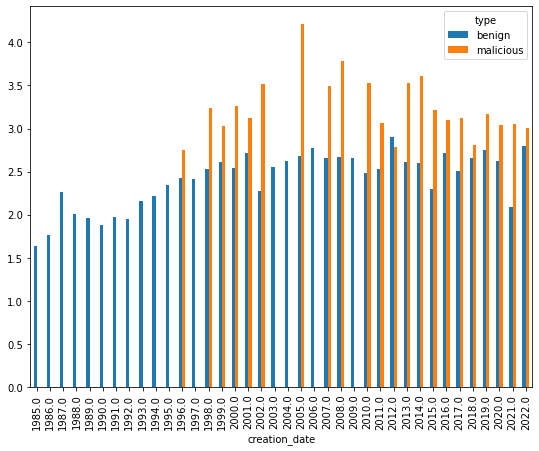

In [36]:
joined_df = whois_df.join(entropy_df, lsuffix='_whois', rsuffix='_entropy').drop(columns='type_entropy').rename(columns={'type_whois': 'type'})
joined_df.groupby([joined_df['creation_date'].dt.year, 'type'])['entropy_value'].mean().unstack('type').plot.bar()

## Plot entropy for only malicious non-shared domains

<AxesSubplot:xlabel='creation_date'>

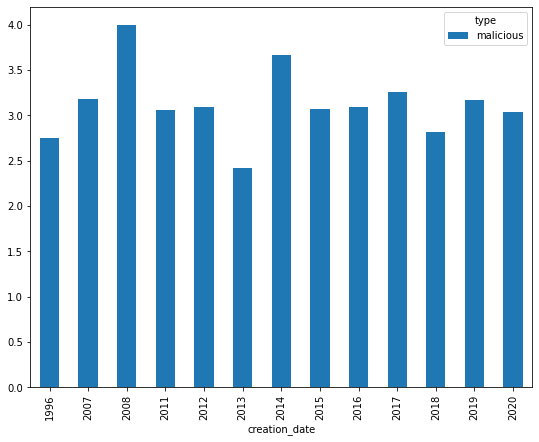

In [37]:
joined_old_not_shared_malicous_df = old_malicious_not_shared_domains_df.set_index('domain_name').join(entropy_df, lsuffix='_whois', rsuffix='_entropy').drop(columns='type_entropy').rename(columns={'type_whois': 'type'})
joined_old_not_shared_malicous_df.groupby([joined_old_not_shared_malicous_df['creation_date'].dt.year, 'type'])['entropy_value'].mean().unstack('type').plot.bar()

## To Test
* Two-tier evaluation...1) is domain likely DGA? 2) is domain likely to be legitimate but hackable?